# Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import dependency

In [2]:
import cv2
import matplotlib.pyplot as plt

import os
import glob
import random
import numpy as np

from tqdm import tqdm

from sklearn.model_selection import train_test_split
from skimage import io, color
from skimage.transform import resize


import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from functools import total_ordering
from torchsummary import summary

## Datasets Creation

In [ ]:
# # import cv2
# # import os

# def save_frame(video_path, output_path, jump):
#     # Create output directory if it doesn't exist
#     os.makedirs(output_path, exist_ok=True)

#     cap = cv2.VideoCapture(video_path)
#     if not cap.isOpened():
#         raise IOError("Cannot open video file")

#     frame_idx = 1
#     current_time = 0.0  # seconds

#     while True:
#         # Set exact timestamp (in milliseconds)
#         cap.set(cv2.CAP_PROP_POS_MSEC, current_time * 1000)

#         ret, frame = cap.read()
#         if not ret:
#             break

#         frame_name = f"frame_{frame_idx:04d}.png"
#         frame_path = os.path.join(output_path, frame_name)

#         cv2.imwrite(frame_path, frame)

#         frame_idx += 1
#         current_time += jump

#     cap.release()
#     print(f"Saved {frame_idx - 1} frames to '{output_path}'")

In [ ]:
# import cv2
# import os
# from tqdm import tqdm

def save_frame(video_path, output_path, jump, size=(256, 256)):
    # Create output directory if it doesn't exist
    os.makedirs(output_path, exist_ok=True)

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise IOError("Cannot open video file")

    # Video duration (seconds)
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    duration = total_frames / fps if fps > 0 else 0

    frame_idx = 1
    current_time = 0.0  # seconds

    with tqdm(total=duration, unit="sec", desc="Extracting frames") as pbar:
        while current_time < duration:
            # Jump to exact timestamp
            cap.set(cv2.CAP_PROP_POS_MSEC, current_time * 1000)

            ret, frame = cap.read()
            if not ret:
                break

            # 🔹 Resize frame to 256x256
            frame = cv2.resize(frame, size, interpolation=cv2.INTER_AREA)

            frame_name = f"frame_{frame_idx:04d}.png"
            frame_path = os.path.join(output_path, frame_name)

            cv2.imwrite(frame_path, frame)

            frame_idx += 1
            current_time += jump
            pbar.update(jump)

    cap.release()
    print(f"Saved {frame_idx - 1} frames (resized to {size}) to '{output_path}'")


In [ ]:
# save_frame('/content/drive/MyDrive/Project/ALLAH AAMAR  SHESH THEKE SHURU  JEET  KOEL  RITABHARI  ARKO  RAJ CHAKRABORTY - Grassroot Entertainment (720p, h264).mp4', '/content/demo', 0.2)

In [ ]:
raw_dataset_dir = '/content/drive/MyDrive/Project/DATASETS'

output_dataset_dir = '/content/drive/MyDrive/Project/move_dataset'

In [ ]:
def create_dataset(raw_dataset_dir, output_dataset_dir, size=(256, 256)):
  search_pattern = os.path.join(raw_dataset_dir, '*.mp4')

  mp4_files_list = glob.glob(search_pattern)

  os.makedirs(output_dataset_dir, exist_ok=True)

  for idx, vedio in enumerate(mp4_files_list):
    print(f"Progress: {idx+1} out of {len(mp4_files_list)}")
    # save_frame(vedio, os.path.join(output_dataset_dir, f"vedio_{idx}"), 0.2)
    save_frame(vedio, os.path.join(output_dataset_dir, f"vedio_{idx}"), 1, size=size)

In [ ]:
# create_dataset(raw_dataset_dir, output_dataset_dir, size=(256, 256))

In [ ]:
# !rm -r "/content/database"

## Helper Utilitis

In [3]:
# import glob
# import os

def find_all_png_paths(directory_path):
    """
    Finds all .png files in the given directory and all its subdirectories.

    Args:
        directory_path (str): The starting directory path.

    Returns:
        list: A list of paths to all .png files found.
    """
    # Create the search pattern: combine the directory path with '**/*.png'
    # os.path.join handles correct path separators for different operating systems
    search_pattern = os.path.join(directory_path, '**', '*.png')

    # Use glob.glob with recursive=True to search subdirectories
    # The ** pattern matches any directory recursively
    png_files = glob.glob(search_pattern, recursive=True)

    return png_files

# # --- Example Usage ---
# # Replace 'your/directory/path' with the path to the directory you want to search
# directory_to_search = '/content/drive/MyDrive/Project/move_dataset'

# # Example using the current working directory for demonstration
# # directory_to_search = os.getcwd()

# try:
#     all_pngs = find_all_png_paths(directory_to_search)

#     print(f"Found {len(all_pngs)} PNG files in '{directory_to_search}':")
#     for png_path in all_pngs:
#         print(png_path)

# except FileNotFoundError:
#     print(f"Error: Directory not found at '{directory_to_search}'")
# except Exception as e:
#     print(f"An error occurred: {e}")


In [4]:
# from skimage import io, color
# from skimage.transform import resize

# def img_to_lab(img_path, shape):
#   img = io.imread(img_path)
#   img =resize(
#     img, shape, anti_aliasing=True
#   )
#   lab = color.rgb2lab(rgb)
#   L = lab[:, :, 0]
#   A = lab[:, :, 1]
#   B = lab[:, :, 2]
#   return L, A, B


In [5]:
# from skimage import io, color
# from skimage.transform import resize

def img_to_lab(img_path, shape):
  img = io.imread(img_path)
  img = resize(
    img, shape, anti_aliasing=True
  )
  lab = color.rgb2lab(img)
  L = lab[:, :, 0]
  AB = lab[:, :, 1:]
  return L, AB

# Dataset Pipeline

In [6]:
BATCH_SIZE = 32

In [7]:
dataset_dir = '/content/drive/MyDrive/BENCOLOR/move_dataset'

In [157]:
all_pngs = find_all_png_paths(dataset_dir)

In [158]:
import random

seed_value = 42

# Set the seed
random.seed(seed_value)

# Shuffle the list in-place
random.shuffle(all_pngs)

In [103]:
# all_pngs = all_pngs[:1000]

In [104]:
# len(all_pngs)

In [159]:
# from sklearn.model_selection import train_test_split

train_paths, val_paths = train_test_split(all_pngs, test_size=0.2, random_state=42)
val_paths, test_paths = train_test_split(val_paths, test_size=0.5, random_state=42)

print(f"Train size: {len(train_paths)}")
print(f"Val size: {len(val_paths)}")
print(f"Test size: {len(test_paths)}")

Train size: 6848
Val size: 856
Test size: 856


In [160]:
# L, AB = img_to_lab(train_paths[0], (256, 256))

In [ ]:
# # import torch
# # from torch.utils.data import Dataset, DataLoader

# class CustomDataset(Dataset):
#     def __init__(self, train_frame_paths, frame_size=(256, 256)):
#         self.train_frame_paths = train_frame_paths
#         self.frame_size = frame_size

#     def __len__(self):
#       return len(self.train_frame_paths)

#     def __getitem__(self, idx):
#       frame_path = self.train_frame_paths[idx]
#       l, ab = img_to_lab(frame_path, self.frame_size)

#       # Normalize 0 to 1
#       l /= 100
#       # Normalize -1 to 1
#       ab /= 128

#       l = torch.from_numpy(l).float() # Cast to float32
#       ab = torch.from_numpy(ab).float() # Cast to float32

#       # Permute dimensions to (channels, height, width) to match model output
#       l = l.unsqueeze(0) # 1xHxW
#       ab = ab.permute(2, 0, 1) # 2xHxW

#       return l, ab

In [161]:
# # import torch
# # from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, train_frame_paths, frame_size=(256, 256)):
        self.train_frame_paths = train_frame_paths
        self.frame_size = frame_size

    def __len__(self):
        return len(self.train_frame_paths)

    def __getitem__(self, idx):
        frame_path = self.train_frame_paths[idx]

        # l: HxW, ab: HxWx2 (NumPy)
        l, ab = img_to_lab(frame_path, self.frame_size)

        # --- SAFE normalization ---
        l = l.astype("float32") / 100.0        # [0, 1]
        ab = ab.astype("float32") / 128.0      # [-1, 1]

        # --- Convert to torch ---
        l = torch.from_numpy(l)                # HxW
        ab = torch.from_numpy(ab)              # HxWx2

        # --- Shape for model ---
        l = l.unsqueeze(0)                     # 1xHxW
        ab = ab.permute(2, 0, 1)               # 2xHxW

        return l, ab

In [162]:
train_dataset = CustomDataset(train_paths)
val_dataset = CustomDataset(val_paths)
test_dataset = CustomDataset(test_paths)

L shape: torch.Size([1, 256, 256])
AB shape: torch.Size([2, 256, 256])


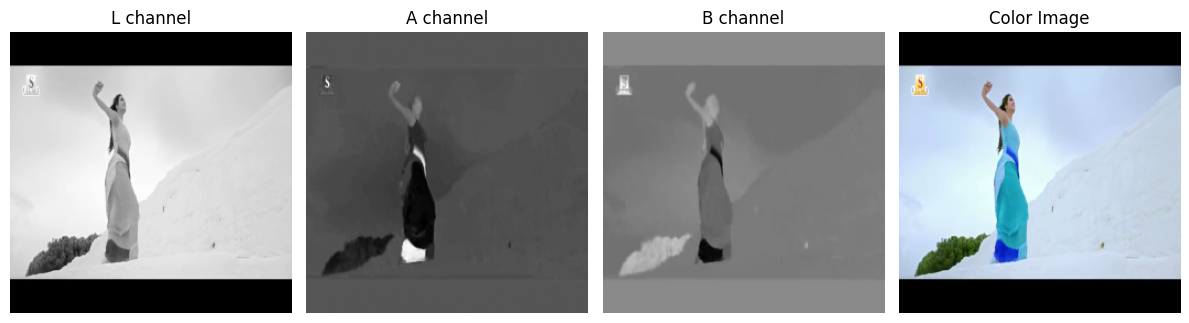

In [163]:
l, ab = train_dataset[24]

print(f"L shape: {l.shape}")
print(f"AB shape: {ab.shape}")

# Convert tensors to numpy
l = l.numpy()
ab = ab.numpy()

# Fix shapes
l = l.squeeze()        # (H, W)
ab = ab.transpose(1, 2, 0)  # (H, W, 2)

fig, ax = plt.subplots(1, 4, figsize=(12, 4))

ax[0].imshow(l, cmap="gray")
ax[0].axis('off')
ax[0].set_title("L channel")

ax[1].imshow(ab[:, :, 0], cmap="gray")
ax[1].axis('off')
ax[1].set_title("A channel")

ax[2].imshow(ab[:, :, 1], cmap="gray")
ax[2].axis('off')
ax[2].set_title("B channel")

color_image = np.zeros((256, 256, 3))
color_image[:, :, 0] = l * 100.0
color_image[:, :, 1:] = ab * 128.0
color_image = color.lab2rgb(color_image)
ax[3].imshow(color_image)
ax[3].axis('off')
ax[3].set_title("Color Image")

plt.tight_layout()
plt.show()

In [ ]:
# for bs in [32, 16, 8, 4]:
#     try:
#         train_dataloader = DataLoader(
#             train_dataset,
#             batch_size=bs,
#             num_workers=2,
#             pin_memory=True
#         )
#         print(f"Batch size {bs}: OK")
#         break
#     except RuntimeError:
#         print(f"Batch size {bs}: OOM")

In [164]:
print(f"Min L: {l.min()}, Max L: {l.max()}")
print(f"Min A: {ab[:, :, 0].min()}, Max A: {ab[:, :, 0].max()}")
print(f"Min B: {ab[:, :, 1].min()}, Max B: {ab[:, :, 1].max()}")

Min L: 0.0, Max L: 0.9975698590278625
Min A: -0.22434096038341522, Max A: 0.4473048746585846
Min B: -0.6824307441711426, Max B: 0.5761814117431641


In [165]:
if torch.cuda.is_available():
    print("CUDA is available!")
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=2, pin_memory=True, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=2, pin_memory=True, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=2, pin_memory=True, shuffle=True)
else:
    print("CUDA is not available. Using CPU.")
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=2, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=2, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=2, shuffle=True)
    # test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=2, shuffle=False)

CUDA is available!


In [166]:
print(f"Train dataloader size: {len(train_dataloader)}")
print(f"Val dataloader size: {len(val_dataloader)}")
print(f"Test dataloader size: {len(test_dataloader)}")

Train dataloader size: 214
Val dataloader size: 27
Test dataloader size: 27


# Auto Encoder

## Models

In [ ]:
# Hyper Parameters
LEARNING_RATE = 0.001
# MOMENTUM = 0.9

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {DEVICE}")

Device: cuda


In [ ]:
import torch
import torch.nn as nn

class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Input Shape: B x 1 x 256 x 256
        # Conv2d(in_channels, out channels, kernal_size, stride, padding)

        # -------- Encoder --------
        self.down1 = nn.Conv2d(1, 64, 3, 2, 1)     # 256 -> 128
        self.down2 = nn.Conv2d(64, 128, 3, 2, 1)   # 128 -> 64
        self.down3 = nn.Conv2d(128, 256, 3, 2, 1)  # 64 -> 32
        self.down4 = nn.Conv2d(256, 512, 3, 2, 1)  # 32 -> 16

        # -------- Decoder --------
        self.up1 = nn.ConvTranspose2d(512, 256, 3, 2, 1, output_padding=1)
        self.up2 = nn.ConvTranspose2d(512, 128, 3, 2, 1, output_padding=1)
        self.up3 = nn.ConvTranspose2d(256, 64, 3, 2, 1, output_padding=1)
        self.up4 = nn.ConvTranspose2d(128, 2, 3, 2, 1, output_padding=1)

        self.relu = nn.ReLU(inplace=True)
        self.tanh = nn.Tanh()

    def forward(self, x):
        # Encoder
        d1 = self.relu(self.down1(x))   # B×64×128×128
        d2 = self.relu(self.down2(d1))  # B×128×64×64
        d3 = self.relu(self.down3(d2))  # B×256×32×32
        d4 = self.relu(self.down4(d3))  # B×512×16×16

        # Decoder
        u1 = self.relu(self.up1(d4))                    # -> 32×32
        u2 = self.relu(self.up2(torch.cat([u1, d3], 1)))
        u3 = self.relu(self.up3(torch.cat([u2, d2], 1)))
        u4 = self.tanh(self.up4(torch.cat([u3, d1], 1)))

        return u4   # B×2×256×256

In [ ]:
# from functools import total_ordering
# Init Model
model = AutoEncoder().to(DEVICE)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params}")
print("Model device:", next(model.parameters()).device)

Total parameters: 3469506
Model device: cuda:0


In [ ]:
# from torchsummary import summary

summary(model, (1, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]             640
              ReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3          [-1, 128, 64, 64]          73,856
              ReLU-4          [-1, 128, 64, 64]               0
            Conv2d-5          [-1, 256, 32, 32]         295,168
              ReLU-6          [-1, 256, 32, 32]               0
            Conv2d-7          [-1, 512, 16, 16]       1,180,160
              ReLU-8          [-1, 512, 16, 16]               0
   ConvTranspose2d-9          [-1, 256, 32, 32]       1,179,904
             ReLU-10          [-1, 256, 32, 32]               0
  ConvTranspose2d-11          [-1, 128, 64, 64]         589,952
             ReLU-12          [-1, 128, 64, 64]               0
  ConvTranspose2d-13         [-1, 64, 128, 128]         147,520
             ReLU-14         [-1, 64, 1

In [ ]:
# Init Optimizer and Loss Function
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

## Traning Loop

### EarlyStopping helper

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0

    def step(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            return False   # do not stop
        else:
            self.counter += 1
            return self.counter >= self.patience

### Validation Function

In [ ]:
def validate(model, val_dataloader, criterion, device):
    model.eval()
    val_loss = 0.0
    total_samples = 0

    with torch.no_grad():
        for l, ab in val_dataloader:
            l = l.to(device)
            ab = ab.to(device)

            predictions = model(l)
            loss = criterion(predictions, ab)

            # ---- Correct loss accumulation ----
            val_loss += loss.item() * l.size(0)
            total_samples += l.size(0)

    # ---- True average loss per sample ----
    return val_loss / total_samples

## Traning and Testing

In [ ]:
# EPOCHS = 50

In [ ]:
# # Define traning loop
# for epoch in range(EPOCHS):
#   running_loss = 0.0

#   for idx, (l, ab) in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
#     # print(f"Type of l from dataloader: {l.dtype}") # Debug print removed
#     # print(f"Type of ab from dataloader: {ab.dtype}") # Debug print removed

#     # l is already 1xHxW from dataset, just move to device
#     l = l.to(DEVICE)
#     ab = ab.to(DEVICE)

#     # Make model prediction
#     predictions = model(l)

#     optimizer.zero_grad()
#     # Calculate loss
#     loss = criterion(predictions, ab)

#     # Backpropagation
#     loss.backward()
#     optimizer.step()

#     running_loss += loss.item()

#   print(f"Epoch: {epoch+1}/{EPOCHS} | Loss: {running_loss/len(train_dataloader):.6f}")

In [ ]:
early_stopper = EarlyStopping(patience=7, min_delta=1e-4)

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    total_samples = 0

    for l, ab in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        l = l.to(DEVICE)
        ab = ab.to(DEVICE)

        optimizer.zero_grad()

        predictions = model(l)
        loss = criterion(predictions, ab)

        loss.backward()
        optimizer.step()

        # ---- Correct loss accumulation ----
        running_loss += loss.item() * l.size(0)
        total_samples += l.size(0)

    # ---- True average loss per sample ----
    train_loss = running_loss / total_samples

    val_loss = validate(model, val_dataloader, criterion, DEVICE)

    print(
        f"Epoch [{epoch+1}/{EPOCHS}] "
        f"Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}"
    )

    # ---- Early stopping ----
    if early_stopper.step(val_loss):
        print(f"Early stopping triggered at epoch {epoch+1}")
        break


In [ ]:
# Test on the testing data
model.eval()
total_loss = 0.0
total_samples = 0

with torch.no_grad():
    for l, ab in tqdm(test_dataloader, total=len(test_dataloader)):
        l = l.to(DEVICE)
        ab = ab.to(DEVICE)

        # Forward pass
        predictions = model(l)

        # Compute loss
        loss = criterion(predictions, ab)

        # Accumulate true loss
        total_loss += loss.item() * l.size(0)
        total_samples += l.size(0)

test_loss = total_loss / total_samples
print(f"\nTest Loss: {test_loss:.6f}")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def show_prediction(l, ab, pred=0):
  fig, ax = plt.subplots(8, 3, figsize=(15,15))
  ax[0, 0].set_title("Grayscale")
  ax[0, 1].set_title("Color")
  ax[0, 2].set_title("Prediction")

  for i in range(8):
    gray_image = l[i].squeeze().numpy() * 100
    ax[i, 0].imshow(gray_image, cmap="gray")
    ax[i, 0].axis('off')

    color_image = np.zeros((256, 256, 3))
    color_image[:, :, 0] = l[i].squeeze().numpy() * 100.0
    color_image[:, :, 1:] = ab[i].squeeze().numpy().transpose(1, 2, 0) * 128.0
    color_image = color.lab2rgb(color_image)
    ax[i, 1].imshow(color_image)
    ax[i, 1].axis('off')

    pred_image = np.zeros((256, 256, 3))
    pred_image[:, :, 0] = l[i].squeeze().numpy() * 100.0
    pred_image[:, :, 1:] = pred[i].squeeze().numpy().transpose(1, 2, 0) * 128.0
    pred_image = color.lab2rgb(pred_image)
    ax[i, 2].imshow(pred_image)
    ax[i, 2].axis('off')

  plt.tight_layout()
  plt.show()

In [ ]:
show_prediction(l.detach().cpu(), ab.detach().cpu(), predictions.detach().cpu())

In [ ]:
# #Save the model
# SAVE_PATH = "/content/drive/MyDrive/Project/model_weights.pth"

# # Source - https://stackoverflow.com/a/43819235
# # Posted by dontloo, modified by community. See post 'Timeline' for change history
# # Retrieved 2026-01-21, License - CC BY-SA 4.0
# torch.save(model.state_dict(), SAVE_PATH)

In [ ]:
# # Load Model
# model.load_state_dict(torch.load('/content/drive/MyDrive/BENCOLOR/MODELS/model_weights.pth', weights_only=True))

# RasNet With Unet

In [167]:
# Hyper Parameters
LEARNING_RATE = 0.001
EPOCHS = 4

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {DEVICE}")

Device: cuda


## Model

In [75]:
# import torch
# import torch.nn as nn

### 1. Basic Conv Block

In [114]:
class ConvBNReLU(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.block(x)

### 2. Residual Block (ResNet-style)

In [115]:
class ResidualBlock(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1):
        super().__init__()

        self.conv1 = ConvBNReLU(in_ch, out_ch, stride)
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_ch, out_ch, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_ch)
        )

        # Projection shortcut if shape changes
        if stride != 1 or in_ch != out_ch:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 1, stride, bias=False),
                nn.BatchNorm2d(out_ch)
            )
        else:
            self.shortcut = nn.Identity()

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = self.shortcut(x)
        out = self.conv1(x)
        out = self.conv2(out)
        out += identity
        return self.relu(out)

### 3. Encoder (pure ResNet logic)

In [116]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.stage1 = ResidualBlock(1, 64, stride=2)   # 256 → 128
        self.stage2 = ResidualBlock(64, 128, stride=2) # 128 → 64
        self.stage3 = ResidualBlock(128, 256, stride=2)# 64 → 32
        self.stage4 = ResidualBlock(256, 512, stride=2)# 32 → 16

    def forward(self, x):
        e1 = self.stage1(x)
        e2 = self.stage2(e1)
        e3 = self.stage3(e2)
        e4 = self.stage4(e3)
        return e1, e2, e3, e4

### 4. Decoder Block (scratch)

In [117]:
class UpBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.up = nn.ConvTranspose2d(
            in_ch, out_ch, kernel_size=3, stride=2, padding=1, output_padding=1
        )
        self.bn = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.bn(self.up(x)))

### 5. Full ResUNet-Style Colorization Model

In [118]:
class ResUNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = Encoder()

        self.up1 = UpBlock(512, 256)
        self.up2 = UpBlock(512, 128)
        self.up3 = UpBlock(256, 64)
        self.up4 = UpBlock(128, 32)

        self.final = nn.Sequential(
            nn.Conv2d(32, 2, kernel_size=1),
            nn.Tanh()
        )

    def forward(self, x):
        e1, e2, e3, e4 = self.encoder(x)

        d1 = self.up1(e4)
        d2 = self.up2(torch.cat([d1, e3], dim=1))
        d3 = self.up3(torch.cat([d2, e2], dim=1))
        d4 = self.up4(torch.cat([d3, e1], dim=1))

        return self.final(d4)

In [119]:
# from functools import total_ordering

model = ResUNet().to(DEVICE)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params}")
print("Model device:", next(model.parameters()).device)

Total parameters: 6815458
Model device: cuda:0


In [ ]:
# from torchsummary import summary

summary(model, (1, 256, 256))

In [121]:
model = torch.compile(model).to(DEVICE)

## Model Modefication

In [ ]:
# import torch
# import torch.nn as nn

#### 1. CNN -> NN -> ReLU

In [34]:
class ConvBNReLU(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, stride, 1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.block(x)

#### 2. Residual Block (ResNet-style)

In [35]:
class ResidualBlock(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1):
        super().__init__()

        self.conv1 = ConvBNReLU(in_ch, out_ch, stride)
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_ch, out_ch, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_ch)
        )

        if stride != 1 or in_ch != out_ch:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 1, stride, bias=False),
                nn.BatchNorm2d(out_ch)
            )
        else:
            self.shortcut = nn.Identity()

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = self.shortcut(x)
        out = self.conv1(x)
        out = self.conv2(out)
        out += identity
        return self.relu(out)

#### 3. SE Attention Block (Lightweight & Effective)

In [36]:
class SEBlock(nn.Module):
    def __init__(self, ch, reduction=16):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(ch, ch // reduction),
            nn.ReLU(inplace=True),
            nn.Linear(ch // reduction, ch),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        # return x * y
        return x + x * y

#### 4. Encoder (Pure ResNet Logic)

In [37]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.e1 = ResidualBlock(1, 64, stride=2)    # 256 -> 128
        self.e2 = ResidualBlock(64, 128, stride=2)  # 128 -> 64
        self.e3 = ResidualBlock(128, 256, stride=2) # 64 -> 32
        self.e4 = ResidualBlock(256, 512, stride=2) # 32 -> 16

    def forward(self, x):
        x1 = self.e1(x)
        x2 = self.e2(x1)
        x3 = self.e3(x2)
        x4 = self.e4(x3)
        return x1, x2, x3, x4

#### 5. Bottleneck (Global Context)

In [38]:
class Bottleneck(nn.Module):
    def __init__(self, ch):
        super().__init__()
        self.block = nn.Sequential(
            ResidualBlock(ch, ch),
            ResidualBlock(ch, ch),
            SEBlock(ch)
        )

    def forward(self, x):
        return self.block(x)

#### 6. Up Block + Residual Refinement

In [39]:
class UpBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.up = nn.ConvTranspose2d(
            in_ch, out_ch, 3, 2, 1, output_padding=1
        )
        self.bn = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU(inplace=True)

        self.refine = nn.Sequential(
            ResidualBlock(out_ch * 2, out_ch),
            # SEBlock(out_ch)
        )

    def forward(self, x, skip):
        x = self.relu(self.bn(self.up(x)))
        x = torch.cat([x, skip], dim=1)
        return self.refine(x)

#### 7. Full ResUNet Colorization Model

In [40]:
class ResUNetColorization(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = Encoder()
        self.bottleneck = Bottleneck(512)

        self.up1 = UpBlock(512, 256)
        self.up2 = UpBlock(256, 128)
        self.up3 = UpBlock(128, 64)
        self.up4 = UpBlock(64, 32)

        self.final = nn.Sequential(
            nn.Conv2d(32, 2, 1),
            nn.Tanh()
        )

    def forward(self, x):
        e1, e2, e3, e4 = self.encoder(x)
        b = self.bottleneck(e4)

        d1 = self.up1(b, e3)
        d2 = self.up2(d1, e2)
        d3 = self.up3(d2, e1)
        d4 = self.up4(d3, x.repeat(1,32,1,1))

        return self.final(d4)

In [ ]:
# model = ResUNetColorization()
# x = torch.randn(4, 1, 256, 256)
# y = model(x)
# print(y.shape)

In [48]:
# from functools import total_ordering

model = ResUNetColorization().to(DEVICE)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params}")
print("Model device:", next(model.parameters()).device)

Total parameters: 18430018
Model device: cuda:0


In [49]:
summary(model, (1, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]              64
       BatchNorm2d-2         [-1, 64, 128, 128]             128
            Conv2d-3         [-1, 64, 128, 128]             576
       BatchNorm2d-4         [-1, 64, 128, 128]             128
              ReLU-5         [-1, 64, 128, 128]               0
        ConvBNReLU-6         [-1, 64, 128, 128]               0
            Conv2d-7         [-1, 64, 128, 128]          36,864
       BatchNorm2d-8         [-1, 64, 128, 128]             128
              ReLU-9         [-1, 64, 128, 128]               0
    ResidualBlock-10         [-1, 64, 128, 128]               0
           Conv2d-11          [-1, 128, 64, 64]           8,192
      BatchNorm2d-12          [-1, 128, 64, 64]             256
           Conv2d-13          [-1, 128, 64, 64]          73,728
      BatchNorm2d-14          [-1, 128,

In [50]:
model = torch.compile(model).to(DEVICE)

## Training Pipeline

In [168]:
# Training pipeline

# criterion = nn.L1Loss()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [123]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0

    def step(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            return False   # do not stop
        else:
            self.counter += 1
            return self.counter >= self.patience

In [124]:
def validate(model, val_dataloader, criterion, device):
    model.eval()
    val_loss = 0.0
    total_samples = 0

    with torch.no_grad():
        for l, ab in val_dataloader:
            l = l.to(device)
            ab = ab.to(device)

            predictions = model(l)
            loss = criterion(predictions, ab)

            val_loss += loss.item() * l.size(0)
            total_samples += l.size(0)

    return val_loss / total_samples


In [125]:
# import torch
# import os

def save_checkpoint(state, is_best, checkpoint_dir="checkpoints"):
    os.makedirs(checkpoint_dir, exist_ok=True)

    # Save latest checkpoint
    latest_path = os.path.join(checkpoint_dir, "last_checkpoint.pth")
    torch.save(state, latest_path)
    print("Saved latest checkpoint")

    # Save best checkpoint
    if is_best:
        best_path = os.path.join(checkpoint_dir, "best_checkpoint.pth")
        torch.save(state, best_path)
        print("Saved best checkpoint")


def load_checkpoint(model, optimizer, checkpoint_path, device):
    checkpoint = torch.load(checkpoint_path, map_location=device)

    model.load_state_dict(checkpoint["model_state"])
    optimizer.load_state_dict(checkpoint["optimizer_state"])

    start_epoch = checkpoint["epoch"] + 1
    best_val_loss = checkpoint["best_val_loss"]
    train_loss_list = checkpoint["train_loss_list"]
    val_loss_list = checkpoint["val_loss_list"]

    print(f"Resumed training from epoch {start_epoch}")

    return start_epoch, best_val_loss, train_loss_list, val_loss_list

In [169]:
START_EPOCH = 0
best_val_loss = float("inf")

checkpoint_dir = "/content/drive/MyDrive/BENCOLOR/checkpoints"
checkpoint_path = "/content/drive/MyDrive/BENCOLOR/checkpoints/last_checkpoint.pth"

train_loss_list = []
val_loss_list = []

if os.path.exists(checkpoint_path):
    START_EPOCH, best_val_loss, train_loss_list, val_loss_list = load_checkpoint(
        model, optimizer, checkpoint_path, DEVICE
    )

In [150]:
# EPOCHS = 40

In [ ]:
early_stopper = EarlyStopping(patience=7, min_delta=1e-4)

for epoch in range(START_EPOCH, EPOCHS):
    model.train()
    running_loss = 0.0
    total_samples = 0

    for l, ab in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        l = l.to(DEVICE)
        ab = ab.to(DEVICE)

        optimizer.zero_grad()

        predictions = model(l)
        loss = criterion(predictions, ab)  # ✅ correct order

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * l.size(0)
        total_samples += l.size(0)

    train_loss = running_loss / total_samples
    val_loss = validate(model, val_dataloader, criterion, DEVICE)

    print(
        f"Epoch [{epoch+1}/{EPOCHS}] "
        f"Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}"
    )

    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)

    # ---- Best model tracking ----
    is_best = val_loss < best_val_loss
    if is_best:
        print(f"Model improved from {best_val_loss:.6f} to {val_loss:.6f}")
        best_val_loss = val_loss

    # ---- Save checkpoint ----
    save_checkpoint(
        state={
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "best_val_loss": best_val_loss,
            "train_loss_list": train_loss_list,
            "val_loss_list": val_loss_list,
        },
        is_best=is_best,
        checkpoint_dir=checkpoint_dir
    )

    # ---- Early stopping ----
    if early_stopper.step(val_loss):
        print(f"Early stopping triggered at epoch {epoch+1}")
        break


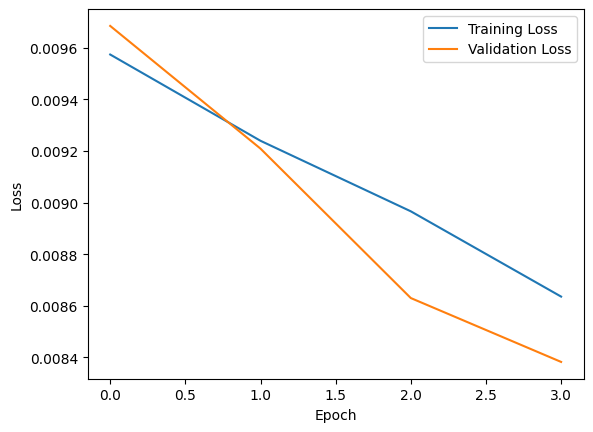

In [173]:
plt.plot(train_loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Testing

In [172]:
# Test on the testing data
model.eval()
total_loss = 0.0
total_samples = 0

with torch.no_grad():
    for l, ab in tqdm(test_dataloader, total=len(test_dataloader)):
        l = l.to(DEVICE)
        ab = ab.to(DEVICE)

        # Forward pass
        predictions = model(l)

        # Compute loss
        loss = criterion(predictions, ab)

        # Accumulate sample-weighted loss
        total_loss += loss.item() * l.size(0)
        total_samples += l.size(0)

test_loss = total_loss / total_samples
print(f"\nTest Loss: {test_loss:.6f}")


100%|██████████| 27/27 [02:06<00:00,  4.70s/it]


Test Loss: 0.008089


In [174]:
# import numpy as np
# import matplotlib.pyplot as plt

def show_prediction(l, ab, pred=0, no_plot=5):
  fig, ax = plt.subplots(no_plot, 3, figsize=(15,15))
  ax[0, 0].set_title("Grayscale")
  ax[0, 1].set_title("Color")
  ax[0, 2].set_title("Prediction")

  for i in range(no_plot):
    gray_image = l[i].squeeze().numpy() * 100
    ax[i, 0].imshow(gray_image, cmap="gray")
    ax[i, 0].axis('off')

    color_image = np.zeros((256, 256, 3))
    color_image[:, :, 0] = l[i].squeeze().numpy() * 100.0
    color_image[:, :, 1:] = ab[i].squeeze().numpy().transpose(1, 2, 0) * 128.0
    color_image = color.lab2rgb(color_image)
    ax[i, 1].imshow(color_image)
    ax[i, 1].axis('off')

    pred_image = np.zeros((256, 256, 3))
    pred_image[:, :, 0] = l[i].squeeze().numpy() * 100.0
    pred_image[:, :, 1:] = pred[i].squeeze().numpy().transpose(1, 2, 0) * 128.0
    pred_image = color.lab2rgb(pred_image)
    ax[i, 2].imshow(pred_image)
    ax[i, 2].axis('off')


  plt.tight_layout()
  plt.show()

In [ ]:
show_prediction(l.detach().cpu(), ab.detach().cpu(), predictions.detach().cpu(), no_plot=min(len(l), 5))

In [ ]:
#Save the model
SAVE_PATH = "/content/drive/MyDrive/BENCOLOR/model_weights_attention.pth"

# Source - https://stackoverflow.com/a/43819235
# Posted by dontloo, modified by community. See post 'Timeline' for change history
# Retrieved 2026-01-21, License - CC BY-SA 4.0
torch.save(model.state_dict(), SAVE_PATH)

In [ ]:
# model.load_state_dict(torch.load('/content/drive/MyDrive/BENCOLOR/model_weights.pth', weights_only=True))

# Compare Model Output

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

def show_prediction_compare(l, ab, pred1=0, pred2=0):
  fig, ax = plt.subplots(5, 3, figsize=(15,15))
  ax[0, 0].set_title("Original")
  ax[0, 1].set_title("Model 1")
  ax[0, 2].set_title("Model 2")

  for i in range(5):
    color_image = np.zeros((256, 256, 3))
    color_image[:, :, 0] = l[i].squeeze().numpy() * 100.0
    color_image[:, :, 1:] = ab[i].squeeze().numpy().transpose(1, 2, 0) * 128.0
    color_image = color.lab2rgb(color_image)

    ax[i, 0].imshow(color_image)
    ax[i, 0].axis('off')

    pred_image = np.zeros((256, 256, 3))
    pred_image[:, :, 0] = l[i].squeeze().numpy() * 100.0
    pred_image[:, :, 1:] = pred1[i].squeeze().numpy().transpose(1, 2, 0) * 128.0
    pred_image = color.lab2rgb(pred_image)

    ax[i, 1].imshow(pred_image)
    ax[i, 1].axis('off')

    pred_image = np.zeros((256, 256, 3))
    pred_image[:, :, 0] = l[i].squeeze().numpy() * 100.0
    pred_image[:, :, 1:] = pred2[i].squeeze().numpy().transpose(1, 2, 0) * 128.0
    pred_image = color.lab2rgb(pred_image)

    ax[i, 2].imshow(pred_image)
    ax[i, 2].axis('off')

  plt.tight_layout()
  plt.show()

In [ ]:
def compare_model(model1, model2):
  # Test on the testing Data
  model1.eval()
  model2.eval()

  total_loss_m1 = 0.0
  total_loss_m2 = 0.0

  with torch.no_grad():
    for idx, (l, ab) in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
      l = l.to(DEVICE)
      ab = ab.to(DEVICE)

      # Make model prediction
      predictions1 = model1(l)
      predictions2 = model2(l)

      # Calculate loss
      loss1 = criterion(predictions1, ab)
      loss2 = criterion(predictions2, ab)

      total_loss_m1 += loss1.item()
      total_loss_m2 += loss2.item()

  print(f"\nTest Loss Model 1: {total_loss_m1/len(test_dataloader):.6f}")
  print(f"\nTest Loss Model 2: {total_loss_m2/len(test_dataloader):.6f}")
  return l, ab, predictions1, predictions2

In [ ]:
model_1 = ResUNet().to(DEVICE)
# model_1.load_state_dict(torch.load('/content/drive/MyDrive/BENCOLOR/model_weights.pth', weights_only=True))

model_1.load_state_dict(torch.load('/content/drive/MyDrive/BENCOLOR/model_weights.pth', map_location=torch.device(DEVICE), weights_only=True))

<All keys matched successfully>

In [ ]:
# model_2 = ResUNet().to(DEVICE)
# model_2.load_state_dict(torch.load('/content/drive/MyDrive/BENCOLOR/model_weights.pth', map_location=torch.device(DEVICE), weights_only=True))

In [ ]:
l, ab, p1, p2 = compare_model(model_1, model)

show_prediction_compare(l.detach().cpu(), ab.detach().cpu(), p1.detach().cpu(), p2.detach().cpu())

In [ ]:
idx = 6

show_prediction_compare(l[idx:].detach().cpu(), ab[idx:].detach().cpu(), p1[idx:].detach().cpu(), p2[idx:].detach().cpu())